## kerasとLSTMの基礎, RNNとの比較

以前の記事でRNNの復習しましたので、ついでにLSTMの復習も行います。LSTMは Long Short Term Memory の略で、長期的な依存関係を学習することのできると言われています。また、RNNの一種で、基本的な考え方は同じです。詳細は検索すればいくらでも出てくるので割愛します。

また、LSTMとRNNの比較を行います。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm/lstm_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm/lstm_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np

import tensorflow as tf
from tensorflow import keras

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.19.4
tensorflow version :  2.1.0
keras version :  2.2.4-tf


## 減衰振動曲線

サンプル用のデータとして、以下の式からサンプリングを行います。

$$
y = \exp\left(-\frac{x}{\tau}\right)\cos(x) 
$$

波を打ちながら、次第に収束していく、自然現象ではよくあるモデルになります。単純なRNNと比較するため、サンプルデータは同じ関数とします。

In [4]:
x = np.linspace(0, 5 * np.pi, 200)
y = np.exp(-x / 5) * (np.cos(x))

### データの確認

$x$と$y$のデータの詳細を見てみます。

In [5]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (200,)
ndim :  1
data :  [0.         0.07893449 0.15786898 0.23680347 0.31573796 0.39467244
 0.47360693 0.55254142 0.63147591 0.7104104 ]


In [6]:
print('shape : ', y.shape)
print('ndim : ', y.ndim)
print('data : ', y[:10])

shape :  (200,)
ndim :  1
data :  [1.         0.98127212 0.9568705  0.92712705 0.89239742 0.85305798
 0.80950282 0.76214062 0.71139167 0.65768474]


グラフを確認してみます。

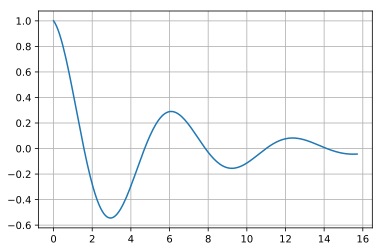

In [7]:
plt.plot(x,y)
plt.grid()
plt.show()

$\tau=5$として、綺麗な減衰曲線が得られました。

## ニューラルネットの構築

kerasに投入するためにデータの前処理を行い、再帰型のニューラルネットの構築を行います。

構築が終了したら、compileメソッドを利用して、モデルをコンパイルします。compileの仕様は以下の様になっています。

```bash
compile(self, optimizer, loss, metrics=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
```

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

NUM_RNN = 20
NUM_MIDDLE = 40

# データの前処理
n = len(x) - NUM_RNN
r_x = np.zeros((n, NUM_RNN))
r_y = np.zeros((n, NUM_RNN))
for i in range(0, n):
  r_x[i] = y[i: i + NUM_RNN]
  r_y[i] = y[i + 1: i + NUM_RNN + 1]

r_x = r_x.reshape(n, NUM_RNN, 1)
r_y = r_y.reshape(n, NUM_RNN, 1)

# RNNニューラルネットの構築
rnn_model = Sequential()
rnn_model.add(SimpleRNN(NUM_MIDDLE, input_shape=(NUM_RNN, 1), return_sequences=True))
rnn_model.add(Dense(1, activation="linear"))
rnn_model.compile(loss="mean_squared_error", optimizer="sgd")

# LSTMニューラルネットの構築
lstm_model = Sequential()
lstm_model.add(LSTM(NUM_MIDDLE, input_shape=(NUM_RNN, 1), return_sequences=True))
lstm_model.add(Dense(1, activation="linear"))
lstm_model.compile(loss="mean_squared_error", optimizer="sgd")

投入するデータや、モデルの概要を確認します。

In [9]:
print(r_y.shape)
print(r_x.shape)

(180, 20, 1)
(180, 20, 1)


二つのモデルの比較を行います。LSTMの方がパラメタ数が多いことがわかります。学習するにもLSTMの方が時間がかかります。

In [10]:
print(rnn_model.summary())
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20, 40)            1680      
_________________________________________________________________
dense (Dense)                (None, 20, 1)             41        
Total params: 1,721
Trainable params: 1,721
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 40)            6720      
_________________________________________________________________
dense_1 (Dense)              (None, 20, 1)             41        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
_________________________________________________________________
None


## 学習

fitメソッドを利用して、学習を行います。
fitメソッドの仕様は以下の通りになっています。[こちら](https://keras.io/ja/models/sequential/)を参照してください。

```bash
fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
```

In [11]:
batch_size = 10
epochs = 1000

# validation_split で最後の10％を検証用に利用します
rnn_history = rnn_model.fit(r_x, r_y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

# validation_split で最後の10％を検証用に利用します
lstm_history = lstm_model.fit(r_x, r_y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

## 損失関数の可視化

学習によって誤差が減少していく様子を可視化してみます。

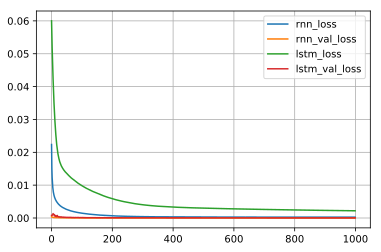

In [12]:
rnn_loss = rnn_history.history['loss'] # 訓練データの損失関数
rnn_val_loss = rnn_history.history['val_loss'] #テストデータの損失関数

lstm_loss = lstm_history.history['loss'] # 訓練データの損失関数
lstm_val_loss = lstm_history.history['val_loss'] #テストデータの損失関数

plt.plot(np.arange(len(rnn_loss)), rnn_loss, label='rnn_loss')
plt.plot(np.arange(len(rnn_val_loss)), rnn_val_loss, label='rnn_val_loss')
plt.plot(np.arange(len(lstm_loss)), lstm_loss, label='lstm_loss')
plt.plot(np.arange(len(lstm_val_loss)), lstm_val_loss, label='lstm_val_loss')
plt.grid()
plt.legend()
plt.show()

## 結果の確認

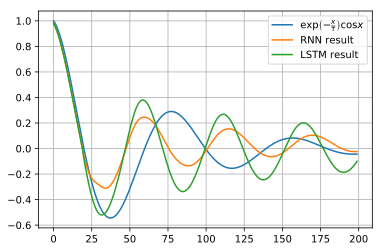

In [13]:
# 初期の入力値
rnn_res = r_y[0].reshape(-1)
lstm_res = r_y[0].reshape(-1)

for i in range(0, n):
  _rnn_y = rnn_model.predict(rnn_res[- NUM_RNN:].reshape(1, NUM_RNN, 1))
  rnn_res = np.append(rnn_res, _rnn_y[0][NUM_RNN - 1][0])
  
  _lstm_y = lstm_model.predict(lstm_res[- NUM_RNN:].reshape(1, NUM_RNN, 1))
  lstm_res = np.append(lstm_res, _lstm_y[0][NUM_RNN - 1][0])
  
plt.plot(np.arange(len(y)), y, label=r"$\exp\left(-\frac{x}{\tau}\right) \cos x$")
plt.plot(np.arange(len(rnn_res)), rnn_res, label="RNN result")
plt.plot(np.arange(len(lstm_res)), lstm_res, label="LSTM result")
plt.legend()
plt.grid()
plt.show()

減衰振動曲線の場合、今回設定したパラメタでは、LSTMとRNNの差は出ていないようです。ただ、実務レベルでは、RNNよりLSTMの方がより使われており、結果も出ているように思います。今回はただの練習なので、ここで終わりにしようと思います。